## Importing all the required libraries

In [32]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Importing NYC subway stations json and storing it as a DataFrame

In [3]:
column_names = ['Stop', 'Latitude', 'Longitude'] 
nysub = pd.DataFrame(columns=column_names)
    
with open('subway nyc.json') as json_data:
    t_data = json.load(json_data) 
for data in t_data['features']:
    stopname = data['properties']['stop_name']        
    cord = data['geometry']['coordinates']
    stop_lat = cord[1]  
    stop_lon = cord[0]  
    
    nysub = nysub.append({'Stop': stopname,
                      'Latitude': stop_lat,
                       'Longitude': stop_lon}, ignore_index=True)

In [78]:
nysub.head()

,Stop,Latitude,Longitude
0,Van Cortlandt Park - 242 St,40.889248,-73.898583
1,238 St,40.884667,-73.900870
2,231 St,40.878856,-73.904834
3,Marble Hill - 225 St,40.874561,-73.909831
4,215 St,40.869444,-73.915279


In [12]:
# Getting Coordinates of New York City

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitudenyc = location.latitude
longitudenyc = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.85048545, -73.8404035580209.


## Plotting all the subway station in NYC

In [20]:
# create map of New York subway
map_nysub = folium.Map(location=[latitudenyc, longitudenyc], zoom_start=10)

# add markers to map
for lat, lng, stop in zip(nysub['Latitude'], nysub['Longitude'], nysub['Stop']):
    label = stop
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nysub)  
    
map_nysub

## Getting the names of stations in The Bronx borough

In [7]:
bronxsubway = pd.read_table('bronxsub.txt', names=('stopsname'))
bronxsubway = pd.DataFrame(bronxsubway['s'])
bronxsubway.columns =['stops']

C:\Users\DELL.ANISH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
C:\Users\DELL.ANISH\Anaconda3\lib\site-packages\pandas\io\parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [49]:
# Creating a Dataframe with stop names and coordinates of only stations in The Bronx

df = bronxsubway.merge(nysub, how = 'left', left_on = 'stops', right_on ='Stop')
df = df.drop('stops',axis=1)
df = df.drop_duplicates(['Stop'], keep = 'last').reset_index(drop=True)

In [18]:
# Getting the coordinate of the Centre of Bronx

address = 'Bronx, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitudebronx = location.latitude
longitudebronx = location.longitude
print('The geograpical coordinate of The Bronx are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of The Bronx are 40.85048545, -74.0060152.


## Plotting all the subway stations in The Bronx

In [50]:
# create map of Bronx Subway
map_bronx = folium.Map(location=[latitudebronx, longitudebronx], zoom_start=12.45)

# add markers to map
for lat, lng, stop in zip(df['Latitude'], df['Longitude'], df['Stop']):
    label = stop
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bronx)  
    
map_bronx

## Getting data using Foursquare API 

In [77]:
CLIENT_ID = 'hidden' # My Foursquare ID
CLIENT_SECRET = 'hidden' # My Foursquare Secret
 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: hidden
CLIENT_SECRET:hidden


In [53]:
# We need all those places that are related to food. We obtain only places under food category from Foursquare

food_category = '4d4b7105d754a06374d81259'

# In the food category we need only our competitors- fast food restaurants, food truck, food stand, cafeteria, burger joints.

Fast_Food_Restaurant = '4bf58dd8d48988d16e941735'
Food_Truck = '4bf58dd8d48988d1cb941735'
Food_Stand = '56aa371be4b08b9a8d57350b'
Cafeteria = '4bf58dd8d48988d128941735'
Burger_Joint = '4bf58dd8d48988d16c941735'

# Function to determine if returned food joint is our client's competitor

def is_competitor(cat_id):
    competitor = None
    if cat_id == '4bf58dd8d48988d16e941735':
        competitor = 'fast food'
    elif cat_id == '4bf58dd8d48988d1cb941735':
        competitor = 'food truck'  
    elif cat_id == '56aa371be4b08b9a8d57350b':
        competitor = 'food stand'
    elif cat_id == '4bf58dd8d48988d128941735':
        competitor = 'cafeteria'
    elif cat_id == '4bf58dd8d48988d16c941735':
        competitor = 'fast food'
    return competitor

# Getting all the nearby place that falls under food category

def getNearbyVenues(names, latitudes, longitudes, category, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    VERSION = '20190724'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            is_competitor(v['venue']['categories'][0]['id'])) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subway Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Food Joint', 
                  'Joint Latitude', 
                  'Joint Longitude', 
                  'Joint Category',
                  'Competitor']
    
    return(nearby_venues)

In [54]:
sub_venues = getNearbyVenues(names=df['Stop'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],
                                   category = food_category
                                  )

In [55]:
# one hot encoding
sub_encode = pd.get_dummies(sub_venues[['Competitor']], prefix="", prefix_sep="")

# add station name column back to dataframe
sub_encode['Subway Station'] = sub_venues['Subway Station'] 

# move station name column to the first column
fixed_columns = [sub_encode.columns[-1]] + list(sub_encode.columns[:-1])
toronto_onehot = sub_encode[fixed_columns]

#grouping by station name and by taking the sum of occurrence of competitor
sub_grouped = sub_encode.groupby('Subway Station').sum().reset_index()

In [87]:
sub_grouped.head()

,Subway Station,fast food,food truck
0,138 St - Grand Concourse,1,0
1,149 St - Grand Concourse,4,1
2,161 St - Yankee Stadium,4,4
3,167 St,2,0
4,170 St,3,0


In [80]:
finaldf = sub_grouped.copy()
finaldf = finaldf.join(df[['Stop','Latitude','Longitude']]).drop('Stop', axis=1)

In [81]:
finaldf.head()

,Subway Station,fast food,food truck,Latitude,Longitude
0,138 St - Grand Concourse,1,0,40.810476,-73.926138
1,149 St - Grand Concourse,4,1,40.816109,-73.917757
2,161 St - Yankee Stadium,4,4,40.813224,-73.929849
3,167 St,2,0,40.818375,-73.927351
4,170 St,3,0,40.827905,-73.925651


## Using K-Means Clustering to cluster subway stations baed on concentration of competitors 

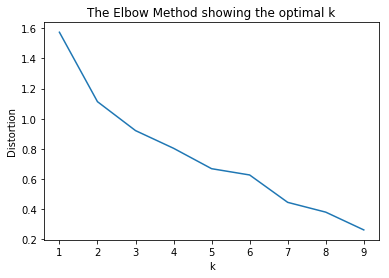

In [65]:
# Finding the right K using Elbow method

sub_grouped_clustering = sub_grouped.drop('Subway Station', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(sub_grouped_clustering)
    kmeanModel.fit(sub_grouped_clustering)
    distortions.append(sum(np.min(cdist(sub_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / sub_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [82]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sub_grouped_clustering)

# add clustering labels
finaldf.insert(1, 'Cluster Labels', kmeans.labels_)

finaldf.head()  

,Subway Station,Cluster Labels,fast food,food truck,Latitude,Longitude
0,138 St - Grand Concourse,1,1,0,40.810476,-73.926138
1,149 St - Grand Concourse,0,4,1,40.816109,-73.917757
2,161 St - Yankee Stadium,2,4,4,40.813224,-73.929849
3,167 St,1,2,0,40.818375,-73.927351
4,170 St,0,3,0,40.827905,-73.925651


## Plotting the clusters with different colours on the map

In [85]:
# create map
map_clusters = folium.Map(location=[latitudebronx, longitudebronx], zoom_start=12)

# set color scheme for the clusters
rainbow = ['red','blue','cyan','green','orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(finaldf['Latitude'], finaldf['Longitude'], finaldf['Subway Station'], finaldf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [70]:
# Not a preferred cluster. High concentration of fast food joints but with a low concentration of food trucks.
finaldf[finaldf['Cluster Labels'] == 0]

,Subway Station,Cluster Labels,fast food,food truck,Latitude,Longitude
1,149 St - Grand Concourse,0,4,1,40.816109,-73.917757
4,170 St,0,3,0,40.827905,-73.925651
13,233 St,0,3,0,40.888022,-73.860341
15,3 Av - 138 St,0,3,0,40.893193,-73.857473
24,Burnside Av,0,4,0,40.853453,-73.907684
36,Intervale Av,0,4,1,40.822181,-73.896736
47,Parkchester,0,3,1,40.833226,-73.860816
48,Pelham Bay Park,0,4,0,40.852462,-73.828121
50,Prospect Av,0,3,2,40.665414,-73.992872
51,Simpson St,0,5,1,40.824073,-73.893064


In [71]:
# Medium prefrence. Low concentration of fastfood joints and very low to none concentration of food trucks. 
finaldf[finaldf['Cluster Labels'] == 1]

,Subway Station,Cluster Labels,fast food,food truck,Latitude,Longitude
0,138 St - Grand Concourse,1,1,0,40.810476,-73.926138
3,167 St,1,2,0,40.818375,-73.927351
5,174 St,1,2,1,40.833771,-73.918440
7,176 St,1,1,1,40.837288,-73.887734
8,182-183 Sts,1,2,0,40.845900,-73.910136
9,183 St,1,2,0,40.848480,-73.911794
10,219 St,1,1,0,40.856093,-73.900741
11,225 St,1,1,0,40.858407,-73.903879
14,238 St,1,2,0,40.878856,-73.904834
17,Allerton Av,1,2,0,40.865462,-73.867352


In [72]:
# Least prefered cluster. High concentration of food trucks and low to medium concentration of fast food joints
finaldf[finaldf['Cluster Labels'] == 2]

,Subway Station,Cluster Labels,fast food,food truck,Latitude,Longitude
2,161 St - Yankee Stadium,2,4,4,40.813224,-73.929849
6,174-175 Sts,2,1,3,40.839306,-73.913400
19,Bedford Park Blvd - Lehman College,2,1,2,40.873412,-73.890064
26,Cypress Av,2,0,2,40.805368,-73.914042
44,Mt Eden Av,2,1,3,40.844434,-73.914685


In [73]:
# There are quite a few fastfood joints even though not many food trucks. Not highly recommended

finaldf[finaldf['Cluster Labels'] == 3]

,Subway Station,Cluster Labels,fast food,food truck,Latitude,Longitude
16,3 Av - 149 St,3,7,0,40.884667,-73.900870
32,Fordham Rd,3,8,2,40.861296,-73.897749
35,Hunts Point Av,3,6,1,40.820948,-73.890549


In [76]:
# The best cluster. They have no fastfood joints or food trucks nearby
finaldf[finaldf['Cluster Labels'] == 4]

,Subway Station,Cluster Labels,fast food,food truck,Latitude,Longitude
12,231 St,4,0,0,40.883895,-73.862633
20,Bronx Park East,4,0,0,40.848828,-73.868457
22,Buhre Av,4,0,0,40.846810,-73.832569
23,Burke Av,4,0,0,40.871356,-73.867164
33,Freeman St,4,0,0,40.829993,-73.891865
34,Gun Hill Rd,4,0,0,40.869526,-73.846384
38,Kingsbridge Rd,4,0,0,40.866978,-73.893509
41,Morris Park,4,0,0,40.854364,-73.860495
49,Pelham Pkwy,4,0,0,40.858985,-73.855359
52,St Lawrence Av,4,0,0,40.831509,-73.867618
